In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1 Load and clean data

In [2]:
# load answer data
# deleted line 801 in both files because it caused an error (had no score -> not usable for training anyway)
column_names = ['Text String 1', 'Text String 2', 'Metadata 1', 'Metadata 2']
df = pd.read_csv('sts2016-english-with-gs-v1.0/STS2016.input.answer-answer.txt', sep='\t', header=None, names=column_names)
# load gs data
data = []
with open('sts2016-english-with-gs-v1.0/STS2016.gs.answer-answer.txt', 'r') as file:
    for line in file:
        # If the line is empty or just contains a newline character, add NaN
        if line.strip() == '':
            data.append([np.nan])
        else:
            # Otherwise, add the value to the data list
            data.append([line.strip()])
            
gs = pd.DataFrame(data, columns=['score'])

In [3]:
df.info()
gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text String 1  1571 non-null   object
 1   Text String 2  1571 non-null   object
 2   Metadata 1     1571 non-null   object
 3   Metadata 2     1571 non-null   object
dtypes: object(4)
memory usage: 49.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   254 non-null    object
dtypes: object(1)
memory usage: 12.4+ KB


In [4]:
# merge dataframes
df = pd.concat([df, gs], axis=1) # concat hier, weil wir keine gemeinsame Spalte haben aber die Reihenfolge gleich ist
df.head()

,Text String 1,Text String 2,Metadata 1,Metadata 2,score
0,Tasting it is the only reliable way.,The way you have it is fine.,StackExchange Network: http://cooking.stackexc...,StackExchange Network: http://writers.stackexc...,NaN
1,I think it probably depends on your money.,It depends on your country.,StackExchange Network: http://workplace.stacke...,StackExchange Network: http://travel.stackexch...,NaN
2,You need to read a lot to know what you like a...,You don't have to know.,StackExchange Network: http://writers.stackexc...,StackExchange Network: http://academia.stackex...,NaN
3,"Obviously, the best book for you depends a lot...",The answer will depend of course on what you'r...,StackExchange Network: http://travel.stackexch...,StackExchange Network: http://travel.stackexch...,NaN
4,I've had this same problem.,I had the same problem as you.,StackExchange Network: http://diy.stackexchang...,StackExchange Network: http://cooking.stackexc...,NaN


In [5]:
# clean data
# 1 convert score to float
df['score'] = pd.to_numeric(df['score'], errors='coerce') # coerce -> if error, set to NaN

# this is the pattern we want to extract
pattern = r'^(.*): (\bhttps?://\S+)'

# apply regex to metadata1 and metadata2 and store it in source_1 source_1_url source_2 source_2_url
df['source_1_url'] = df['Metadata 1'].str.extract(pattern)[1]
df['source_2_url'] = df['Metadata 2'].str.extract(pattern)[1]

# rename all columns to use snake_case
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns = df.columns.str.strip(' ')

In [6]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text_string_1  1571 non-null   object 
 1   text_string_2  1571 non-null   object 
 2   metadata_1     1571 non-null   object 
 3   metadata_2     1571 non-null   object 
 4   score          254 non-null    float64
 5   source_1_url   1571 non-null   object 
 6   source_2_url   1571 non-null   object 
dtypes: float64(1), object(6)
memory usage: 86.0+ KB


,text_string_1,text_string_2,metadata_1,metadata_2,score,source_1_url,source_2_url
0,Tasting it is the only reliable way.,The way you have it is fine.,StackExchange Network: http://cooking.stackexc...,StackExchange Network: http://writers.stackexc...,NaN,http://cooking.stackexchange.com/questions/5611,http://writers.stackexchange.com/questions/11017
1,I think it probably depends on your money.,It depends on your country.,StackExchange Network: http://workplace.stacke...,StackExchange Network: http://travel.stackexch...,NaN,http://workplace.stackexchange.com/questions/1755,http://travel.stackexchange.com/questions/45030
2,You need to read a lot to know what you like a...,You don't have to know.,StackExchange Network: http://writers.stackexc...,StackExchange Network: http://academia.stackex...,NaN,http://writers.stackexchange.com/questions/12166,http://academia.stackexchange.com/questions/26241
3,"Obviously, the best book for you depends a lot...",The answer will depend of course on what you'r...,StackExchange Network: http://travel.stackexch...,StackExchange Network: http://travel.stackexch...,NaN,http://travel.stackexchange.com/questions/4582,http://travel.stackexchange.com/questions/23436
4,I've had this same problem.,I had the same problem as you.,StackExchange Network: http://diy.stackexchang...,StackExchange Network: http://cooking.stackexc...,NaN,http://diy.stackexchange.com/questions/2138,http://cooking.stackexchange.com/questions/12500


In [7]:
def get_topic(text):
    topic_match = re.search(r"http://([\w.-]+)\.stackexchange", text)
    if topic_match:
        topic = topic_match.group(1)
    else:
        topic = np.nan
        
    return topic

In [8]:
df['topic_1'] = df['source_1_url'].apply(get_topic)
df['topic_2'] = df['source_2_url'].apply(get_topic)
df.head()

,text_string_1,text_string_2,metadata_1,metadata_2,score,source_1_url,source_2_url,topic_1,topic_2
0,Tasting it is the only reliable way.,The way you have it is fine.,StackExchange Network: http://cooking.stackexc...,StackExchange Network: http://writers.stackexc...,NaN,http://cooking.stackexchange.com/questions/5611,http://writers.stackexchange.com/questions/11017,cooking,writers
1,I think it probably depends on your money.,It depends on your country.,StackExchange Network: http://workplace.stacke...,StackExchange Network: http://travel.stackexch...,NaN,http://workplace.stackexchange.com/questions/1755,http://travel.stackexchange.com/questions/45030,workplace,travel
2,You need to read a lot to know what you like a...,You don't have to know.,StackExchange Network: http://writers.stackexc...,StackExchange Network: http://academia.stackex...,NaN,http://writers.stackexchange.com/questions/12166,http://academia.stackexchange.com/questions/26241,writers,academia
3,"Obviously, the best book for you depends a lot...",The answer will depend of course on what you'r...,StackExchange Network: http://travel.stackexch...,StackExchange Network: http://travel.stackexch...,NaN,http://travel.stackexchange.com/questions/4582,http://travel.stackexchange.com/questions/23436,travel,travel
4,I've had this same problem.,I had the same problem as you.,StackExchange Network: http://diy.stackexchang...,StackExchange Network: http://cooking.stackexc...,NaN,http://diy.stackexchange.com/questions/2138,http://cooking.stackexchange.com/questions/12500,diy,cooking


# 2 Describe Dataset and explain features (TODO)

* was stellen die Scores dar ? (TODO)

# 3 Statistics and Viz (Done)

### Univariate Analysis
* Text Length (Done)
* Source Distribution (Done)
* Score Distribution (Done)
* (Sätze sind nicht einzigartig, d.h. Sätze können mehrmals vorkommen) (Done)

### Bivariate Analysis

* Text Length vs Score (Done)

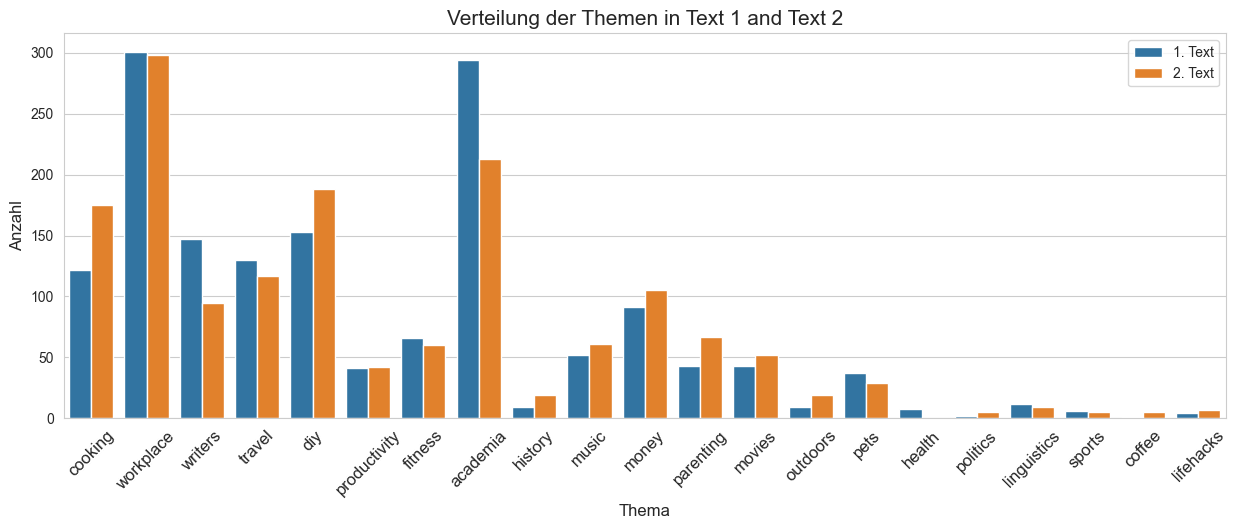

In [9]:
# Verteilung der Themen in Text 1 and Text 2
df_topics = pd.melt(df, value_vars=['topic_1', 'topic_2'], var_name='Topics', value_name='Category')
ax = plt.figure(figsize=(15, 5))
sns.countplot(data=df_topics, x='Category', hue='Topics')
plt.xticks(rotation=45, size=12)
plt.legend(labels=['1. Text', '2. Text'])
plt.title('Verteilung der Themen in Text 1 and Text 2', size=15)
plt.xlabel('Thema', size=12)
plt.ylabel('Anzahl', size=12)
plt.show()

# Anmerkungen für das PDF
# hierbei ist anzumerken, dass die Themen nicht immer gleich sind, d.h es gibt auch Textpaare, die nicht das gleiche Thema haben aber es ist trozdem interessant zu sehen, welche Themen am häufigsten vorkommen

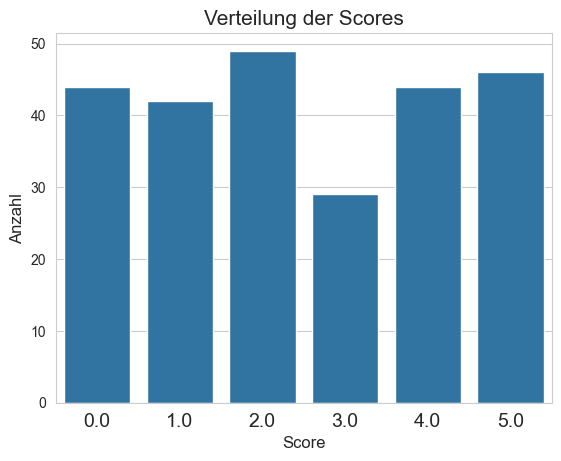

Anzahl Textpaare: 1571
Anzahl fehlender Scores: 1317
Anzahl Scores: 254
Anteil fehlender Scores: 83.83%
Anteil Scores: 16.17%


In [10]:
# Verteilung der Scores (Anzahl)
sns.countplot(data=df, x='score')
plt.xticks(size=14)
plt.title('Verteilung der Scores', size=15)
plt.xlabel('Score', size=12)
plt.ylabel('Anzahl', size=12)
plt.show()

# Anmerkungen für das PDF
missing_scores = df['score'].isna().sum()
print(f'Anzahl Textpaare: {len(df)}')
print(f'Anzahl fehlender Scores: {missing_scores}')
print(f'Anzahl Scores: {len(df) - missing_scores}')
print(f'Anteil fehlender Scores: {missing_scores / len(df) * 100:.2f}%')
print(f'Anteil Scores: {(len(df) - missing_scores) / len(df) * 100:.2f}%')

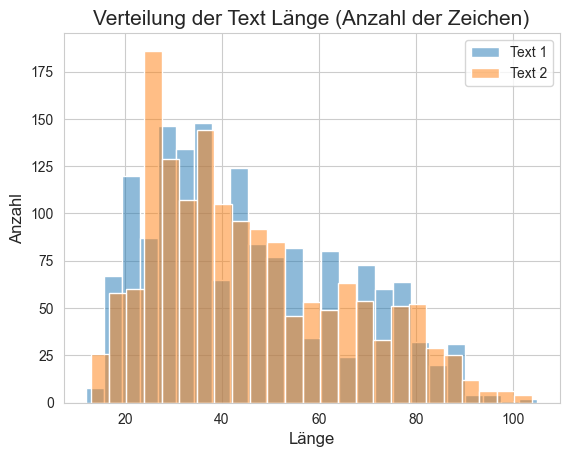

Durchschnittliche Textlänge Text 1: 45.39
Durchschnittliche Textlänge Text 2: 45.60
Median Textlänge Text 1: 42.00
Median Textlänge Text 2: 41.00


In [11]:
# Text Längen
df['text_1_length'] = df['text_string_1'].str.len()
df['text_2_length'] = df['text_string_2'].str.len()
sns.histplot(data=df, x='text_1_length', bins=25, alpha=0.5, label='Text 1')
sns.histplot(data=df, x='text_2_length', bins=25, alpha=0.5, label='Text 2')
plt.title('Verteilung der Text Länge (Anzahl der Zeichen)', size=15)
plt.xlabel('Länge', size=12)
plt.ylabel('Anzahl', size=12)
plt.legend()
plt.show()

# Anmerkungen für das PDF
print(f'Durchschnittliche Textlänge Text 1: {df["text_1_length"].mean():.2f}')
print(f'Durchschnittliche Textlänge Text 2: {df["text_2_length"].mean():.2f}')
print(f'Median Textlänge Text 1: {df["text_1_length"].median():.2f}')
print(f'Median Textlänge Text 2: {df["text_2_length"].median():.2f}')

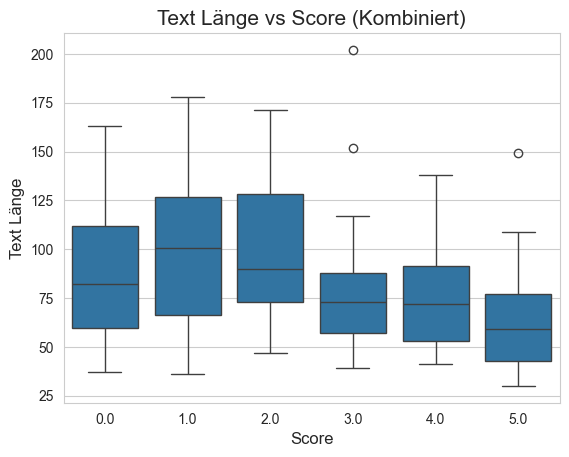

Korrelation zwischen Text Länge und Score: -0.31


In [12]:
# Text Längen vs Score
df_no_nan_scores = df.dropna(subset=['score'])
df_no_nan_scores = df_no_nan_scores.copy()
df_no_nan_scores['combined_text_length'] = df_no_nan_scores['text_1_length'] + df_no_nan_scores['text_2_length']
sns.boxplot(data=df_no_nan_scores, x='score', y='combined_text_length')
plt.title('Text Länge vs Score (Kombiniert)', size=15)
plt.xlabel('Score', size=12)
plt.ylabel('Text Länge', size=12)
plt.show()
print(f'Korrelation zwischen Text Länge und Score: {df_no_nan_scores["combined_text_length"].corr(df_no_nan_scores["score"]):.2f}')

In [13]:
df

,text_string_1,text_string_2,metadata_1,metadata_2,score,source_1_url,source_2_url,topic_1,topic_2,text_1_length,text_2_length
0,Tasting it is the only reliable way.,The way you have it is fine.,StackExchange Network: http://cooking.stackexc...,StackExchange Network: http://writers.stackexc...,NaN,http://cooking.stackexchange.com/questions/5611,http://writers.stackexchange.com/questions/11017,cooking,writers,36,28
1,I think it probably depends on your money.,It depends on your country.,StackExchange Network: http://workplace.stacke...,StackExchange Network: http://travel.stackexch...,NaN,http://workplace.stackexchange.com/questions/1755,http://travel.stackexchange.com/questions/45030,workplace,travel,42,27
2,You need to read a lot to know what you like a...,You don't have to know.,StackExchange Network: http://writers.stackexc...,StackExchange Network: http://academia.stackex...,NaN,http://writers.stackexchange.com/questions/12166,http://academia.stackexchange.com/questions/26241,writers,academia,64,23
3,"Obviously, the best book for you depends a lot...",The answer will depend of course on what you'r...,StackExchange Network: http://travel.stackexch...,StackExchange Network: http://travel.stackexch...,NaN,http://travel.stackexchange.com/questions/4582,http://travel.stackexchange.com/questions/23436,travel,travel,75,74
4,I've had this same problem.,I had the same problem as you.,StackExchange Network: http://diy.stackexchang...,StackExchange Network: http://cooking.stackexc...,NaN,http://diy.stackexchange.com/questions/2138,http://cooking.stackexchange.com/questions/12500,diy,cooking,27,30
...,...,...,...,...,...,...,...,...,...,...,...
1566,You are on the right path.,You are right about the overtaking rules.,StackExchange Network: http://money.stackexcha...,StackExchange Network: http://travel.stackexch...,NaN,http://money.stackexchange.com/questions/22386,http://travel.stackexchange.com/questions/13783,money,travel,26,41
1567,This is a terrible idea.,This is a bad idea.,StackExchange Network: http://fitness.stackexc...,StackExchange Network: http://cooking.stackexc...,5.0,http://fitness.stackexchange.com/questions/23636,http://cooking.stackexchange.com/questions/42032,fitness,cooking,24,19
1568,I have the same thing.,I have had the same issue last couple of years.,StackExchange Network: http://diy.stackexchang...,StackExchange Network: http://pets.stackexchan...,NaN,http://diy.stackexchange.com/questions/19977,http://pets.stackexchange.com/questions/208,diy,pets,22,47
1569,I don't think it makes any tremendous difference.,I don't think that there's any.,StackExchange Network: http://cooking.stackexc...,StackExchange Network: http://academia.stackex...,NaN,http://cooking.stackexchange.com/questions/9442,http://academia.stackexchange.com/questions/27341,cooking,academia,49,31


In [14]:
# create a new df with all sentences
df_sentences = pd.DataFrame(columns=['sentence'])
df_sentences['sentence'] = pd.concat([df['text_string_1'], df['text_string_2']]).reset_index(drop=True)
df_sentences['sentence'].value_counts()

# Anmerkungen für das PDF
print(f'Anzahl der Sätze: {len(df_sentences)}')
print(f'Anzahl der einzigartigen Sätze: {len(df_sentences["sentence"].unique())}')
print(f'Anzahl der doppelten Sätze: {len(df_sentences) - len(df_sentences["sentence"].unique())}')
print()
# Die drei meist vorkommenden Sätze
print(df_sentences['sentence'].value_counts()[:3])

Anzahl der Sätze: 3142
Anzahl der einzigartigen Sätze: 1607
Anzahl der doppelten Sätze: 1535

sentence
You need to read a lot to know what you like and what you don't.        39
It depends on what you want to do next, and where you want to do it.    38
You don't have to know.                                                 37
Name: count, dtype: int64


# Betrachten der anderen Datenstätze

Es gibt 4 weitere Datenstätze, die wir uns anschauen können. Diese sind:

* sts2016-english-with-gs-v1.0/STS2016.input.headlines.txt
* sts2016-english-with-gs-v1.0/STS2016.input.plagiarism.txt
* sts2016-english-with-gs-v1.0/STS2016.input.postediting.txt
* sts2016-english-with-gs-v1.0/STS2016.input.question-question.txt

die jeweiligen gs Dateien sind:

* sts2016-english-with-gs-v1.0/STS2016.gs.headlines.txt
* sts2016-english-with-gs-v1.0/STS2016.gs.plagiarism.txt
* sts2016-english-with-gs-v1.0/STS2016.gs.postediting.txt
* sts2016-english-with-gs-v1.0/STS2016.gs.question-question.txt

## plagiarism

In [15]:
# load text data
column_names = ['Text String 1', 'Text String 2', 'Metadata 1', 'Metadata 2']
df_plagiarism = pd.read_csv('sts2016-english-with-gs-v1.0/STS2016.input.plagiarism.txt', sep='\t', header=None, names=column_names)
# load gs data
data = []
with open('sts2016-english-with-gs-v1.0/STS2016.gs.plagiarism.txt', 'r') as file:
    for line in file:
        # If the line is empty or just contains a newline character, add NaN
        if line.strip() == '':
            data.append([np.nan])
        else:
            # Otherwise, add the value to the data list
            data.append([line.strip()])

gs_plagiarism = pd.DataFrame(data, columns=['score'])

gs_plagiarism.info()
df_plagiarism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   230 non-null    object
dtypes: object(1)
memory usage: 10.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text String 1  1271 non-null   object
 1   Text String 2  1271 non-null   object
 2   Metadata 1     1271 non-null   object
 3   Metadata 2     1271 non-null   object
dtypes: object(4)
memory usage: 39.8+ KB


In [16]:
df_plagiarism = pd.concat([df_plagiarism, gs_plagiarism], axis=1)   
df_plagiarism.head()

,Text String 1,Text String 2,Metadata 1,Metadata 2,score
0,The vector space model has some limitations: 1.,The vector space model are the documents which...,A Corpus of Plagiarised Short Answers - http:/...,A Corpus of Plagiarised Short Answers - http:/...,NaN
1,Secondly to define the value of the optimal so...,Define value of optimal solution recursively.,A Corpus of Plagiarised Short Answers - http:/...,A Corpus of Plagiarised Short Answers - http:/...,NaN
2,Vector space representation results in the los...,"If a term occurs in the document, the value wi...",A Corpus of Plagiarised Short Answers - http:/...,A Corpus of Plagiarised Short Answers - http:/...,1
3,P(B) is the prior or marginal probability of B...,"P(A), or the probability that the student is a...",A Corpus of Plagiarised Short Answers - http:/...,A Corpus of Plagiarised Short Answers - http:/...,NaN
4,"It is ""prior"" in the sense that it does not ta...","It is ""previous"" in the sense that it does not...",A Corpus of Plagiarised Short Answers - http:/...,A Corpus of Plagiarised Short Answers - http:/...,NaN


In [17]:
print(f'Anzahl Textpaare: {len(df_plagiarism)}')
print(f'Anzahl fehlender Scores: {df_plagiarism["score"].isna().sum()}')
print(f'Anzahl Scores: {len(df_plagiarism) - df_plagiarism["score"].isna().sum()}')

Anzahl Textpaare: 1271
Anzahl fehlender Scores: 1041
Anzahl Scores: 230


## headlines

In [18]:
df_headlines = pd.read_csv('sts2016-english-with-gs-v1.0/STS2016.input.headlines.txt', sep='\t', header=None, names=column_names)
data = []
with open('sts2016-english-with-gs-v1.0/STS2016.gs.headlines.txt', 'r') as file:
    for line in file:
        # If the line is empty or just contains a newline character, add NaN
        if line.strip() == '':
            data.append([np.nan])
        else:
            # Otherwise, add the value to the data list
            data.append([line.strip()])
            
gs_headlines = pd.DataFrame(data, columns=['score'])

df_headlines.info()
gs_headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text String 1  1498 non-null   object
 1   Text String 2  1498 non-null   object
 2   Metadata 1     1498 non-null   object
 3   Metadata 2     1498 non-null   object
dtypes: object(4)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   249 non-null    object
dtypes: object(1)
memory usage: 11.8+ KB


In [19]:
df_headlines = pd.concat([df_headlines, gs_headlines], axis=1)
df_headlines.head()

,Text String 1,Text String 2,Metadata 1,Metadata 2,score
0,Digital era threatens tenuous future of drive-ins,Digital Era Threatens Future of Drive-Ins,Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),NaN
1,Jessica Lal murder convict Manu Sharma gets 15...,Jessica murder Manu Sharma gets parole,Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),NaN
2,UN to hold emergency DR Congo talks,U.N. Council to Hold Emergency DR Congo Talks,Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),NaN
3,Iran and IAEA resume nuclear talks,"Iran, IAEA resume nuclear talks in Tehran",Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),NaN
4,Thai protesters storm army headquarters,Thai protestors storm Royal army headquarters ...,Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),NaN


In [20]:
print(f'Anzahl Textpaare: {len(df_headlines)}')
print(f'Anzahl fehlender Scores: {df_headlines["score"].isna().sum()}')
print(f'Anzahl Scores: {len(df_headlines) - df_headlines["score"].isna().sum()}')

Anzahl Textpaare: 1498
Anzahl fehlender Scores: 1249
Anzahl Scores: 249


## postediting

In [21]:
df_postediting = pd.read_csv('sts2016-english-with-gs-v1.0/STS2016.input.postediting.txt', sep='\t', header=None, on_bad_lines='warn', names=column_names)
data = []
with open('sts2016-english-with-gs-v1.0/STS2016.gs.postediting.txt', 'r') as file:
    for line in file:
        # If the line is empty or just contains a newline character, add NaN
        if line.strip() == '':
            data.append([np.nan])
        else:
            # Otherwise, add the value to the data list
            data.append([line.strip()])

gs_postediting = pd.DataFrame(data, columns=['score'])

df_postediting.info()
gs_postediting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3033 entries, 0 to 3032
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text String 1  3033 non-null   object
 1   Text String 2  3033 non-null   object
 2   Metadata 1     3033 non-null   object
 3   Metadata 2     2961 non-null   object
dtypes: object(4)
memory usage: 94.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   244 non-null    object
dtypes: object(1)
memory usage: 25.8+ KB


Skipping line 50: expected 4 fields, saw 6
Skipping line 196: expected 4 fields, saw 5
Skipping line 208: expected 4 fields, saw 5
Skipping line 281: expected 4 fields, saw 5
Skipping line 344: expected 4 fields, saw 5
Skipping line 390: expected 4 fields, saw 5
Skipping line 552: expected 4 fields, saw 5
Skipping line 705: expected 4 fields, saw 6
Skipping line 893: expected 4 fields, saw 5
Skipping line 1068: expected 4 fields, saw 5
Skipping line 1071: expected 4 fields, saw 5
Skipping line 1159: expected 4 fields, saw 5
Skipping line 1206: expected 4 fields, saw 5
Skipping line 1469: expected 4 fields, saw 5
Skipping line 1488: expected 4 fields, saw 6
Skipping line 1540: expected 4 fields, saw 5
Skipping line 1578: expected 4 fields, saw 5
Skipping line 1696: expected 4 fields, saw 5
Skipping line 1820: expected 4 fields, saw 5
Skipping line 1839: expected 4 fields, saw 5
Skipping line 1860: expected 4 fields, saw 5
Skipping line 1985: expected 4 fields, saw 5
Skipping line 1999: 

In [22]:
df_postediting.head()

,Text String 1,Text String 2,Metadata 1,Metadata 2
0,"Not only PAMPLEMOUSSE - according to experts, ...",That FEBRUARY PAMPLEMOUSSE- According to the e...,EAMT11 post-editting dataset (http://staffwww....,EAMT11 post-editting dataset (http://staffwww....
1,"The fact that the OSCE, during the evaluation ...","The fact that the OSCE, during the evaluation ...",EAMT11 post-editting dataset (http://staffwww....,EAMT11 post-editting dataset (http://staffwww....
2,"In the Czech Republic, no chance, say the mobi...","In the Czech Republic, no chance, say the mobi...",EAMT11 post-editting dataset (http://staffwww....,EAMT11 post-editting dataset (http://staffwww....
3,I already knew the word thanks to my mangas.,I already knew thanks to my mangas.,EAMT11 post-editting dataset (http://staffwww....,EAMT11 post-editting dataset (http://staffwww....
4,"Before off for the US, Nicolas Sarkozy will ta...","Before leaving for the US, Nicolas Sarkozy wil...",EAMT11 post-editting dataset (http://staffwww....,EAMT11 post-editting dataset (http://staffwww....


Das postediting file hat viele Zeilen die nicht richtig eingelesen werden können. Deswegen verzichten wir an dieser Stelle auf eine genaue Analyse dieses Datensatzes.

## question-question

In [23]:
df_question_question = pd.read_csv('sts2016-english-with-gs-v1.0/STS2016.input.question-question.txt', sep='\t', header=None, names=column_names)
data = []
with open('sts2016-english-with-gs-v1.0/STS2016.gs.question-question.txt', 'r') as file:
    for line in file:
        # If the line is empty or just contains a newline character, add NaN
        if line.strip() == '':
            data.append([np.nan])
        else:
            # Otherwise, add the value to the data list
            data.append([line.strip()])

gs_question_question = pd.DataFrame(data, columns=['score'])

df_question_question.info()
gs_question_question.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1555 entries, 0 to 1554
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text String 1  1555 non-null   object
 1   Text String 2  1555 non-null   object
 2   Metadata 1     1555 non-null   object
 3   Metadata 2     1555 non-null   object
dtypes: object(4)
memory usage: 48.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1555 entries, 0 to 1554
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   209 non-null    object
dtypes: object(1)
memory usage: 12.3+ KB


In [24]:
df_question_question = pd.concat([df_question_question, gs_question_question], axis=1)
df_question_question.head()

,Text String 1,Text String 2,Metadata 1,Metadata 2,score
0,Should I drink water during my workout?,How can I get my toddler to drink more water?,StackExchange Network: http://fitness.stackexc...,StackExchange Network: http://parenting.stacke...,NaN
1,How can I put something in book format without...,"How can I ""time-stamp"" my data without publish...",StackExchange Network: http://writers.stackexc...,StackExchange Network: http://academia.stackex...,NaN
2,How do I stop my dog from jumping on me?,How do I make my dog forget a command?,StackExchange Network: http://pets.stackexchan...,StackExchange Network: http://pets.stackexchan...,NaN
3,What's the best way to store asparagus?,What's the correct way to store fats?,StackExchange Network: http://cooking.stackexc...,StackExchange Network: http://cooking.stackexc...,NaN
4,How do I make a height adjustable desk?,How can I build a wall mounted adjustable heig...,StackExchange Network: http://diy.stackexchang...,StackExchange Network: http://diy.stackexchang...,4


In [25]:
print(f'Anzahl Textpaare: {len(df_question_question)}')
print(f'Anzahl fehlender Scores: {df_question_question["score"].isna().sum()}')
print(f'Anzahl Scores: {len(df_question_question) - df_question_question["score"].isna().sum()}')

Anzahl Textpaare: 1555
Anzahl fehlender Scores: 1346
Anzahl Scores: 209
